In [1]:
#link kaggle: https://www.kaggle.com/hnganhlnguyn/ex5-rnn-lstm-2
#Author by Hung Anh

In [2]:
!nvidia-smi

Fri Nov 12 17:54:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

<h1>Prepare</h1>

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import datetime

In [4]:
# LSTM for air pollution problem with regression framing
import numpy
import matplotlib.pyplot as plt
import math
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization
from tensorflow.keras.layers import LSTM,Bidirectional
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [5]:
dataset = pd.read_csv('../input/aapldataset/AAPL.csv',index_col=0)

In [6]:
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-11-14,26.927500,26.952499,26.020000,26.427500,24.825821,204702000
2016-11-15,26.642500,26.920000,26.540001,26.777500,25.154610,129058000
2016-11-16,26.674999,27.557501,26.650000,27.497499,25.830971,235362000
2016-11-17,27.452499,27.587500,27.207500,27.487499,25.821573,110528000
2016-11-18,27.430000,27.635000,27.415001,27.514999,25.847408,113715600


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1008 entries, 2016-11-14 to 2020-11-13
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1008 non-null   float64
 1   High       1008 non-null   float64
 2   Low        1008 non-null   float64
 3   Close      1008 non-null   float64
 4   Adj Close  1008 non-null   float64
 5   Volume     1008 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 55.1+ KB


In [8]:
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1.008000e+03
mean,55.022847,55.634645,54.439440,55.068780,53.661965,1.279139e+08
std,22.808228,23.199504,22.329356,22.778370,23.265842,5.914382e+07
min,26.642500,26.920000,26.020000,26.427500,24.825821,2.880380e+07
25%,39.973123,40.278123,39.636251,39.968751,38.069605,8.788140e+07
50%,47.244999,47.631248,46.872500,47.197500,45.769047,1.118354e+08
75%,61.968749,63.971249,61.203751,62.090624,61.046269,1.499102e+08
max,137.589996,137.979996,130.529999,134.179993,133.948898,4.479400e+08


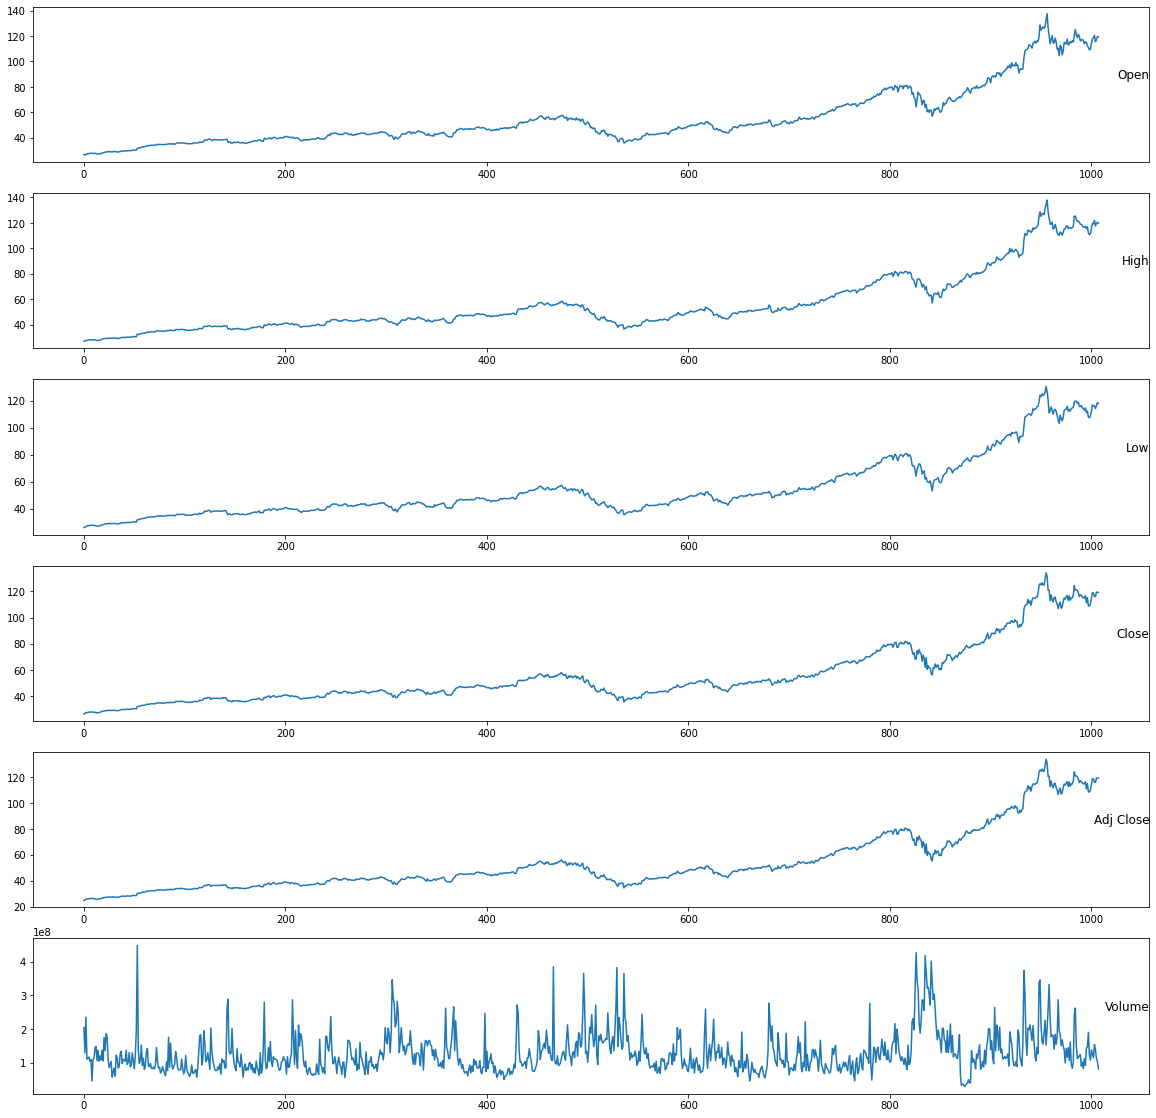

In [9]:
values = dataset.values
groups = [0,1,2,3,4,5] # Vì cột 4 là kiểu chuỗi
i=1
plt.figure(figsize=(20,20))
for group in groups:
    plt.subplot(len(groups),1,i)
    plt.plot(values[:,group])
    plt.title(dataset.columns[group],y=0.5,loc='right')
    i+=1
plt.show()

In [10]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))        
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True) # kết quả sau khi drop gán luôn vào agg
    return agg

In [11]:
#ensure all data is float
values = values.astype('float32')
#normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(values)
scaled = scaler.transform(values)
print('Frame as Series:')
print(scaled[:5])
#frame as supervised learning
reframed = series_to_supervised(scaled,1,1)
print('Frame as supervised learning: ')
print(reframed.head())

Frame as Series:
[[2.5687814e-03 2.9262900e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
  4.1966838e-01]
 [0.0000000e+00 0.0000000e+00 4.9756020e-03 3.2481849e-03 3.0130148e-03
  2.3919241e-01]
 [2.9292703e-04 5.7401359e-03 6.0281307e-03 9.9301785e-03 9.2111528e-03
  4.9281877e-01]
 [7.3007494e-03 6.0102493e-03 1.1362538e-02 9.8373443e-03 9.1250390e-03
  1.9498245e-01]
 [7.0979595e-03 6.4379573e-03 1.3347998e-02 1.0092571e-02 9.3617886e-03
  2.0258759e-01]]
Frame as supervised learning: 
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)  \
1   0.002569   0.000293   0.000000   0.000000   0.000000   0.419668  0.000000   
2   0.000000   0.000000   0.004976   0.003248   0.003013   0.239192  0.000293   
3   0.000293   0.005740   0.006028   0.009930   0.009211   0.492819  0.007301   
4   0.007301   0.006010   0.011363   0.009837   0.009125   0.194982  0.007098   
5   0.007098   0.006438   0.013348   0.010093   0.009362   0.202588  0.007999   

    var2(t)   var3(

In [12]:
#drop columns we don't want to predict
reframed.drop(reframed.columns[[7,8,9,10,11]],axis = 1,inplace = True)
print("Frame will use:")
print(reframed.head())

Frame will use:
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)
1   0.002569   0.000293   0.000000   0.000000   0.000000   0.419668  0.000000
2   0.000000   0.000000   0.004976   0.003248   0.003013   0.239192  0.000293
3   0.000293   0.005740   0.006028   0.009930   0.009211   0.492819  0.007301
4   0.007301   0.006010   0.011363   0.009837   0.009125   0.194982  0.007098
5   0.007098   0.006438   0.013348   0.010093   0.009362   0.202588  0.007999


<h1>Split data</h1>

In [13]:
# cột var1(t) là cột cần dự đoán,

In [14]:
values = reframed.values
n_train_hours = int(0.7*len(dataset))

In [15]:
train = values[:n_train_hours,:]
# còn lại thì là test
test = values[n_train_hours:,:]
#split into input and output (các cột đầu, cột cuối)
train_X,train_y = train[:,:-1],train[:,-1]
test_X,test_y = test[:,:-1],test[:,-1]
print('Before reshape:')
print(train_X.shape,train_y.shape,test_X.shape,test_y.shape)
# reshape input to be 3D [samples,timesteps,features]
train_X = train_X.reshape((train_X.shape[0],1,train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0],1,test_X.shape[1]))
print('After reshape:')
print(train_X.shape,train_y.shape,test_X.shape,test_y.shape)

Before reshape:
(705, 6) (705,) (302, 6) (302,)
After reshape:
(705, 1, 6) (705,) (302, 1, 6) (302,)


<h1>Build and Train Model</h1>

In [16]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

early_stopping = EarlyStopping(min_delta=0.000001,
                              patience = 50,
                              restore_best_weights=True)
learning_rate = ReduceLROnPlateau(patience=10,verbose=1,factor=0.5,min_delta=0.000001)

In [17]:
import datetime
model = Sequential()
model.add(LSTM(200, activation='relu', return_sequences = True,input_shape = (train_X.shape[1],train_X.shape[2])))
model.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(1, 2)))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(25, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

2021-11-12 17:54:23.559943: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 17:54:23.571393: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 17:54:23.572607: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 17:54:23.574254: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 200)            165600    
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 200)            320800    
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 100)            120400    
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 50)             30200     
_________________________________________________________________
lstm_4 (LSTM)                (None, 25)                7600      
_________________________________________________________________
dense (Dense)                (None, 20)                520       
_________________________________________________________________
dropout (Dropout)            (None, 20)                0

In [19]:
# Fitting the RNN to the Training set
t0 = datetime.datetime.now()
history = model.fit(train_X, train_y, validation_data=(test_X,test_y),epochs = 1000, batch_size = 128,callbacks=[early_stopping,learning_rate])
t1 = datetime.datetime.now()

Epoch 1/1000


2021-11-12 17:54:25.302207: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


6/6 [==============================] - 7s 273ms/step - loss: 0.0224 - val_loss: 0.2675
Epoch 2/1000
6/6 [==============================] - 0s 31ms/step - loss: 0.0142 - val_loss: 0.2333
Epoch 3/1000
6/6 [==============================] - 0s 32ms/step - loss: 0.0083 - val_loss: 0.2018
Epoch 4/1000
6/6 [==============================] - 0s 37ms/step - loss: 0.0052 - val_loss: 0.1767
Epoch 5/1000
6/6 [==============================] - 0s 37ms/step - loss: 0.0049 - val_loss: 0.1631
Epoch 6/1000
6/6 [==============================] - 0s 31ms/step - loss: 0.0049 - val_loss: 0.1609
Epoch 7/1000
6/6 [==============================] - 0s 30ms/step - loss: 0.0048 - val_loss: 0.1662
Epoch 8/1000
6/6 [==============================] - 0s 33ms/step - loss: 0.0048 - val_loss: 0.1733
Epoch 9/1000
6/6 [==============================] - 0s 29ms/step - loss: 0.0045 - val_loss: 0.1781
Epoch 10/1000
6/6 [==============================] - 0s 32ms/step - loss: 0.0044 - val_loss: 0.1786
Epoch 11/1000
6/6 [==

In [20]:
print('Time training: ',t1-t0)

Time training:  0:00:19.158350


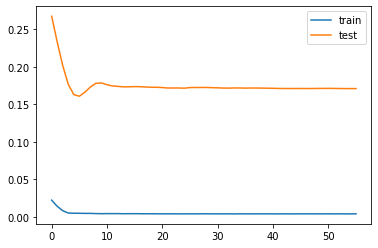

In [21]:
#plot 
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

In [22]:
model2 = Sequential()
model2.add(Bidirectional(LSTM(200, activation='relu', return_sequences = True,input_shape = (train_X.shape[1],train_X.shape[2]))))
model2.add(Bidirectional(LSTM(200, activation='relu', return_sequences=True, input_shape=(1, 2))))
model2.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True)))
model2.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True)))
model2.add(Bidirectional(LSTM(25, activation='relu')))
model2.add(Dense(20, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(10, activation='relu'))
model2.add(Dense(1))

# Compiling the RNN
model2.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [23]:
# Fitting the RNN to the Training set
t0 = datetime.datetime.now()
history2 = model2.fit(train_X, train_y, validation_data=(test_X,test_y),epochs = 1000, batch_size = 128,callbacks=[early_stopping,learning_rate])
t1 = datetime.datetime.now()

Epoch 1/1000
6/6 [==============================] - 14s 332ms/step - loss: 0.0233 - val_loss: 0.2770
Epoch 2/1000
6/6 [==============================] - 0s 49ms/step - loss: 0.0176 - val_loss: 0.2536
Epoch 3/1000
6/6 [==============================] - 0s 51ms/step - loss: 0.0124 - val_loss: 0.2300
Epoch 4/1000
6/6 [==============================] - 0s 50ms/step - loss: 0.0086 - val_loss: 0.2072
Epoch 5/1000
6/6 [==============================] - 0s 52ms/step - loss: 0.0064 - val_loss: 0.1857
Epoch 6/1000
6/6 [==============================] - 0s 48ms/step - loss: 0.0054 - val_loss: 0.1703
Epoch 7/1000
6/6 [==============================] - 0s 50ms/step - loss: 0.0057 - val_loss: 0.1667
Epoch 8/1000
6/6 [==============================] - 0s 54ms/step - loss: 0.0054 - val_loss: 0.1698
Epoch 9/1000
6/6 [==============================] - 0s 53ms/step - loss: 0.0048 - val_loss: 0.1737
Epoch 10/1000
6/6 [==============================] - 0s 53ms/step - loss: 0.0047 - val_loss: 0.1751
Epoch 1

In [27]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 1, 400)            331200    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1, 400)            961600    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1, 200)            400800    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 1, 100)            100400    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 50)                25200     
_________________________________________________________________
dense_3 (Dense)              (None, 20)                1020      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)               

In [28]:
print('Time training: ',t1-t0)

Time training:  0:01:18.628173


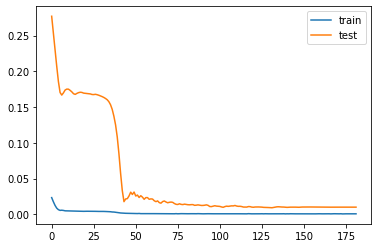

In [29]:
#plot 
plt.plot(history2.history['loss'],label='train')
plt.plot(history2.history['val_loss'],label='test')
plt.legend()
plt.show()

<h2>Nhận xét</h2>
<li>Thông qua việc sử dụng Bidirectional LSTM thì ta thấy model2 cải thiện hơn model1 rất nhiều</li>

In [30]:
def invert_scaling(y, X, s):
    # invert scaling for forecast
    inv_y = np.concatenate((y, X[:,1:]), axis=1)
    print(s, "shape:", inv_y.shape)
    inv_y = scaler.inverse_transform(inv_y)
    print(s, inv_y.shape)
    # trả lại hình dạng ban đầu
    inv_y = inv_y[:,0]
    return inv_y

In [31]:
yhat = model2.predict(test_X)
print("Test_x_shape:",test_X.shape)
test_X_now= test_X.reshape((test_X.shape[0],test_X.shape[2]))
test_X_now.shape

Test_x_shape: (302, 1, 6)


(302, 6)

In [32]:
inv_yhat = invert_scaling(yhat,test_X_now,"inv_yhat")

inv_yhat shape: (302, 6)
inv_yhat (302, 6)


In [33]:
test_y = test_y.reshape((len(test_y),1))
inv_y = invert_scaling(test_y,test_X_now,"inv_y")

inv_y shape: (302, 6)
inv_y (302, 6)


In [34]:
rmse = math.sqrt(mean_squared_error(inv_y,inv_yhat))
print('Test RMSE: %.3f'%rmse)
mae = mean_absolute_error(inv_y,inv_yhat)
print("Test MAE: %.3f"%mae)

Test RMSE: 10.596
Test MAE: 9.669


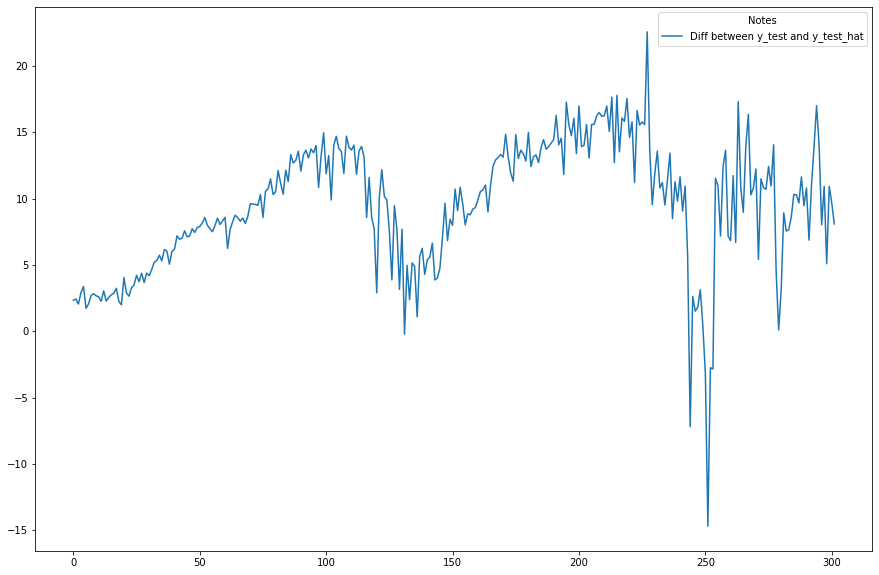

In [35]:
plt.figure(figsize=(15,10))
plt.plot(inv_y-inv_yhat,label="Diff between y_test and y_test_hat")
plt.legend(title='Notes')
plt.show()

In [36]:
y_train_hat = model2.predict(train_X)
train_X_now = train_X.reshape((train_X.shape[0],train_X.shape[2]))

inv_y_train_hat = invert_scaling(y_train_hat,train_X_now,"inv_y_train_hat")

inv_y_train_hat shape: (705, 6)
inv_y_train_hat (705, 6)


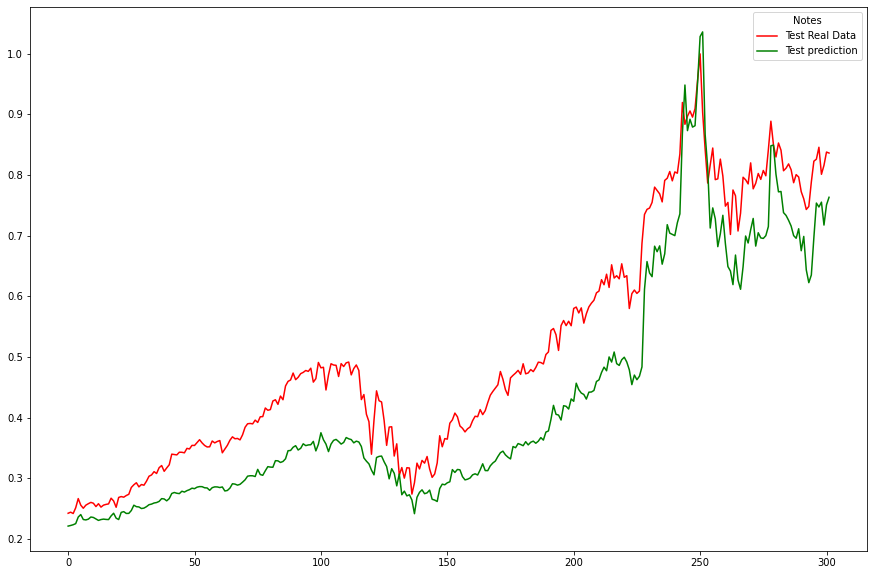

In [37]:
plt.figure(figsize=(15,10))
plt.plot(test_y,label='Test Real Data',color='red')
plt.plot(yhat,label='Test prediction',color ='green')
plt.legend(title='Notes')
plt.show()

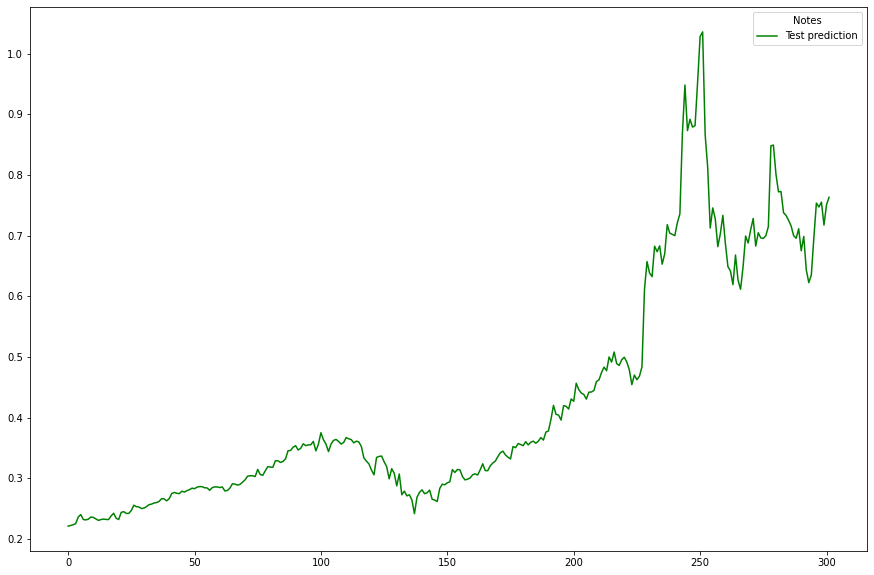

In [38]:
plt.figure(figsize=(15,10))
plt.plot(yhat,label='Test prediction',color ='green')
plt.legend(title='Notes')
plt.show()

In [39]:
print('val_loss train')
model2.evaluate(train_X,train_y)

val_loss train
23/23 [==============================] - 0s 8ms/step - loss: 1.3861e-04


0.0001386146614095196

In [40]:
print('val_loss test')
model2.evaluate(test_X,test_y)

val_loss test
10/10 [==============================] - 1s 6ms/step - loss: 0.0091


0.009121732786297798

In [41]:
model2.save('Ex5Model2BiLinear.h5')